In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement  # save reference for measurement table
Station = Base.classes.station  # save reference to station table

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<AxesSubplot:xlabel='date'>

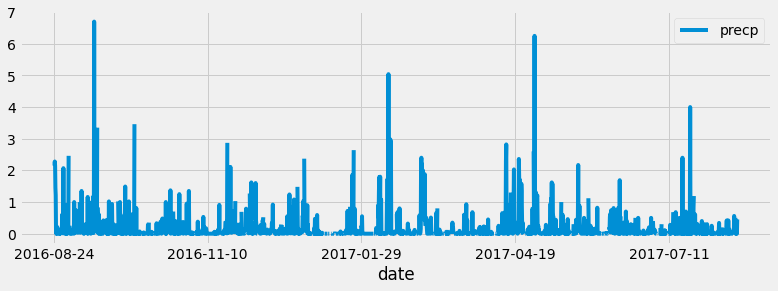

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# find last date in database from Measurements (should be = 2017-08-23 00:00:00)
last_date = last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# convert last date string to date format
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")

# calculate exactly one year prior to the last date available
from_date = last_date - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= from_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year_data, columns=['date', 'precp'])
last_year_df.set_index(last_year_df['date'], inplace=True)

# Sort the dataframe by date
last_year_df = last_year_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot(figsize=(12,4))

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,precp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.count(Station.station)).all()
print(f"There are {stations_count[0][0]} stations in this dataset.")

There are 9 stations in this dataset.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

count = lambda x: x[1]   # since we are getting tuples with the count being the second element
stations.sort(reverse=True,key=count)  # reverse=True will sort the list in descending order. (high to low)

for station in stations:
    print(f"Station Id: {station[0]} Count: {station[1]}")

Station Id: USC00519281 Count: 2772
Station Id: USC00519397 Count: 2724
Station Id: USC00513117 Count: 2709
Station Id: USC00519523 Count: 2669
Station Id: USC00516128 Count: 2612
Station Id: USC00514830 Count: 2202
Station Id: USC00511918 Count: 1979
Station Id: USC00517948 Count: 1372
Station Id: USC00518838 Count: 511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station? (station id = USC00519281)
top_station = stations[0][0]

stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == top_station).all()  # will return a list with a tuple containing the values

lowest,highest,mean = stats[0]  # since stats is a list with ONE tuple in it, we can just unpack the data 

print(f"The lowest temp recorded was: {lowest}.")
print(f"The highest temp recorded was: {highest}.")
print(f"The average temp recorded was: {mean}.")

The lowest temp recorded was: 54.0.
The highest temp recorded was: 85.0.
The average temp recorded was: 71.66378066378067.


<AxesSubplot:ylabel='Frequency'>

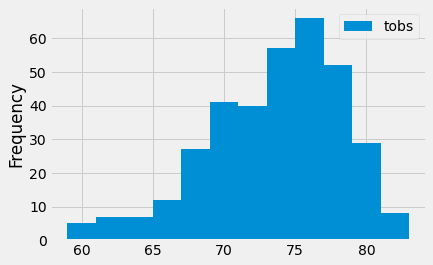

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_year_obs = session.query(Measurement.tobs).\
    filter(Measurement.station == top_station).filter(Measurement.date >= from_date).all()

top_station_df = pd.DataFrame(top_station_year_obs, columns=['tobs'])

top_station_df.plot.hist(bins=12)

---
## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps(from_date, last_date)
print(temps)

[(58.0, 74.57894736842105, 87.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

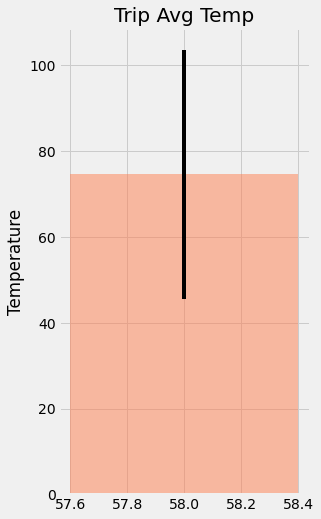

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
avg_temp = plt.bar(((temps[0])[0]), ((temps[0])[1]),  yerr=(((temps[0])[2])-((temps[0])[0])),alpha=0.5,
                   color='coral', align="center")
plt.ylabel('Temperature')
plt.title('Trip Avg Temp')

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query_columns = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*query_columns).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= from_date).\
    filter(Measurement.date <= last_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

sort = lambda x: x[2]
results.sort(reverse=True, key=sort)  # sort from highest to lowest by Precipitation (3rd element in tuple)

for s in results:
    print(f"Station Id: {s[0]}, Name: {s[1]}, PRCP: {s[2]}, LAT: {s[3]}, LNG: {s[4]}, ELEVATION: {s[5]}\n")

Station Id: USC00514830, Name: KUALOA RANCH HEADQUARTERS 886.9, HI US, PRCP: 21.5213, LAT: -157.8374, LNG: 7.0, ELEVATION: 33.19

Station Id: USC00519281, Name: WAIHEE 837.5, HI US, PRCP: 21.45167, LAT: -157.84888999999998, LNG: 32.9, ELEVATION: 68.24000000000002

Station Id: USC00513117, Name: KANEOHE 838.1, HI US, PRCP: 21.4234, LAT: -157.8015, LNG: 14.6, ELEVATION: 48.36000000000003

Station Id: USC00517948, Name: PEARL CITY, HI US, PRCP: 21.3934, LAT: -157.9751, LNG: 11.9, ELEVATION: 4.59

Station Id: USC00519523, Name: WAIMANALO EXPERIMENTAL FARM, HI US, PRCP: 21.33556, LAT: -157.71139, LNG: 19.5, ELEVATION: 37.99

Station Id: USC00516128, Name: MANOA LYON ARBO 785.2, HI US, PRCP: 21.3331, LAT: -157.8025, LNG: 152.4, ELEVATION: 147.11000000000004

Station Id: USC00519397, Name: WAIKIKI 717.2, HI US, PRCP: 21.2716, LAT: -157.8168, LNG: 3.0, ELEVATION: 16.089999999999986



In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# For the dates of my trip (May 11-20), calculate the daily normals
dates = ['05-11','05-12','05-13','05-14','05-15','05-16','05-17','05-18','05-19','05-20']
normals = []

for date in dates:  # Loop through the list of %m-%d strings and calculate the normals for each date
    for temperature in daily_normals(date):
        normals.append(temperature)  # append to list
print(normals)

[(65.0, 73.61111111111111, 79.0), (65.0, 73.13793103448276, 79.0), (67.0, 73.14285714285714, 79.0), (63.0, 73.89285714285714, 80.0), (63.0, 73.69090909090909, 79.0), (68.0, 74.37931034482759, 80.0), (68.0, 74.45, 79.0), (68.0, 74.10714285714286, 82.0), (65.0, 73.80701754385964, 79.0), (68.0, 73.89655172413794, 79.0)]


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Minimum Temperature', 'Average Temperature', 'Maximum Temperature'],
                          index=dates)
normals_df

,Minimum Temperature,Average Temperature,Maximum Temperature
05-11,65.0,73.611111,79.0
05-12,65.0,73.137931,79.0
05-13,67.0,73.142857,79.0
05-14,63.0,73.892857,80.0
05-15,63.0,73.690909,79.0
05-16,68.0,74.379310,80.0
05-17,68.0,74.450000,79.0
05-18,68.0,74.107143,82.0
05-19,65.0,73.807018,79.0
05-20,68.0,73.896552,79.0


<AxesSubplot:title={'center':'Trip Daily Normals: May 11-20'}>

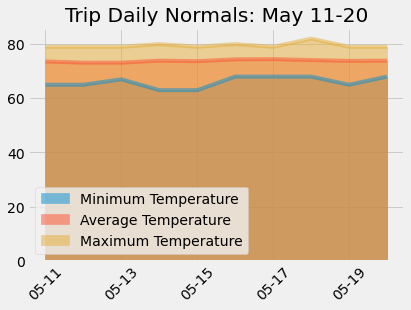

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, rot = 45,title="Trip Daily Normals: May 11-20")